# Fourier Shell Correlation applied to evaluating reconstruction results

Ideally for FRC/FSC analysis one would have two independent observations of the region-of-interest. With 3D stacks, if only using a single detector, such a requirement is not very practical -- as acquiring two stacks will double the acquisition time and increase photobleaching. Also there's a plethora of existing image datasets on most researchers hard drives that might be of interest to analayse. 

For these reason I wanted to see if it would be possible to get a reasonable resolution estimate from a single stack only, by splitting it into two sub-stacks. 

In [68]:
%matplotlib inline
from ipywidgets import interact, fixed

import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
from supertomo.analysis.resolution.fourier_shell_correlation import DirectionalFSC
import supertomo.data.iterators.fourier_shell_iterators as iterators
import supertomo.analysis.resolution.analysis as fsc_analysis


def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Data

A single 3D stack of a pollen sample was acquired with a Nikon A1 confocal microscope. First the dataset was resampled to isotropic spacing and zero padded to a cube -- after which it was split in two by using a checkerboard pattern. 

In [69]:
# Image
data_dir = os.path.join(os.getcwd(), "data")
image_name = "2015-03-tubulin-fixed-raw.mha"

# Get script options
args_list = [data_dir, '--bin-delta=12', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=fixed', '--resolution-threshold-value=0.5',
            '--angle-delta=15', '--enable-hollow-iterator', '--extract-angle-delta=.1', 
             '--resolution-point-sigma=0.01']
args = options.get_frc_script_options(args_list)

# Get image
image = read.get_image(os.path.join(data_dir, image_name), channel=0)

# Pre-process
image = imops.zoom_to_isotropic_spacing(image, order=0)
image = imops.zero_pad_to_cube(image)
image = imops.crop_to_shape(image, [500]*3)

image1, image2 = imops.checkerboard_split(image)

interact(show_axial_slice, image1=fixed(image1), image2=fixed(image2), slice=(0, image1.shape[0]-1))

interactive(children=(IntSlider(value=124, description=u'slice', max=249), Output()), _dom_classes=('widget-interact',))

<function __main__.show_axial_slice>

In [70]:
iterator = iterators.HollowConicalFourierShellIterator(image1.shape, args.d_bin, args.d_angle, args.d_extract_angle)
fsc_task = DirectionalFSC(image1, image2, iterator)
data = fsc_task.execute()


Angle
0      Axes(0.125,0.125;0.775x0.775)
15     Axes(0.125,0.125;0.775x0.775)
30     Axes(0.125,0.125;0.775x0.775)
45     Axes(0.125,0.125;0.775x0.775)
60     Axes(0.125,0.125;0.775x0.775)
75     Axes(0.125,0.125;0.775x0.775)
90     Axes(0.125,0.125;0.775x0.775)
105    Axes(0.125,0.125;0.775x0.775)
120    Axes(0.125,0.125;0.775x0.775)
135    Axes(0.125,0.125;0.775x0.775)
150    Axes(0.125,0.125;0.775x0.775)
165    Axes(0.125,0.125;0.775x0.775)
180    Axes(0.125,0.125;0.775x0.775)
195    Axes(0.125,0.125;0.775x0.775)
210    Axes(0.125,0.125;0.775x0.775)
225    Axes(0.125,0.125;0.775x0.775)
240    Axes(0.125,0.125;0.775x0.775)
255    Axes(0.125,0.125;0.775x0.775)
270    Axes(0.125,0.125;0.775x0.775)
285    Axes(0.125,0.125;0.775x0.775)
300    Axes(0.125,0.125;0.775x0.775)
315    Axes(0.125,0.125;0.775x0.775)
330    Axes(0.125,0.125;0.775x0.775)
345    Axes(0.125,0.125;0.775x0.775)
dtype: object

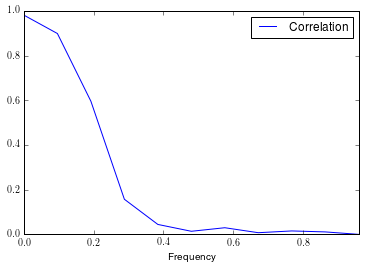

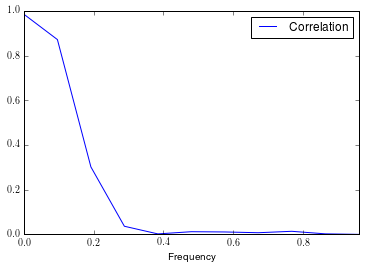

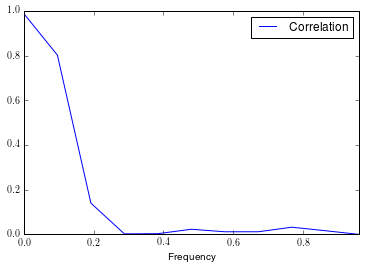

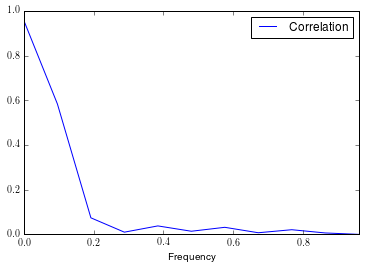

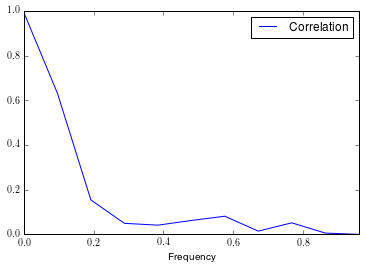

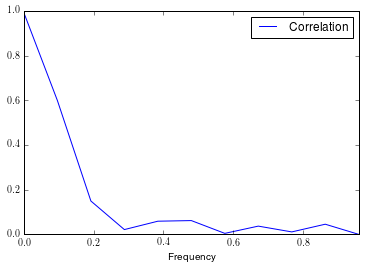

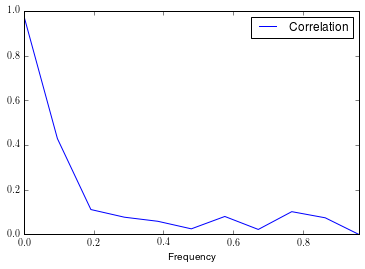

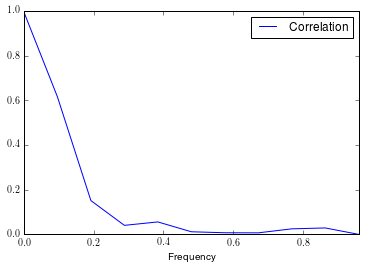

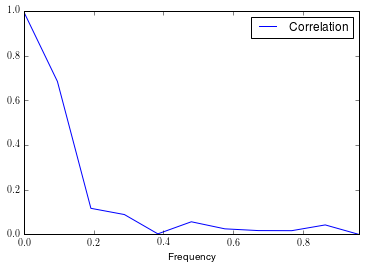

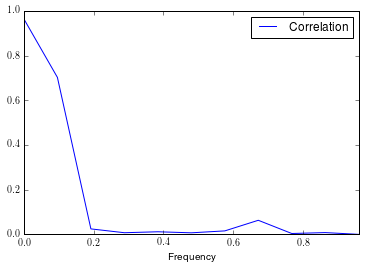

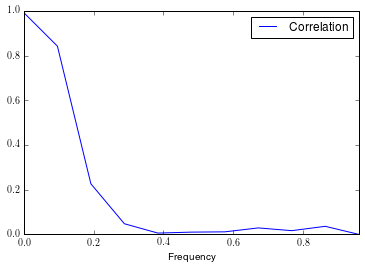

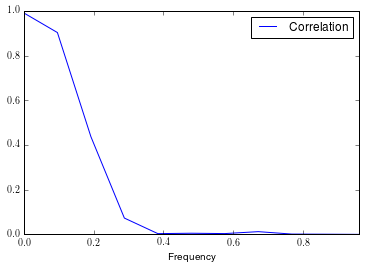

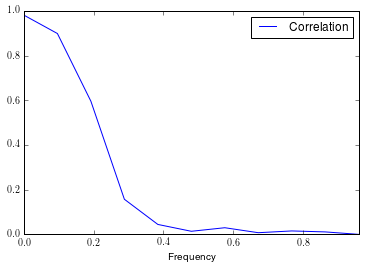

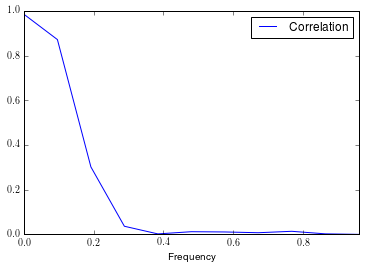

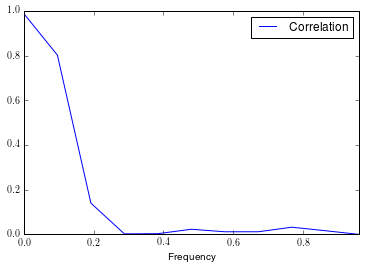

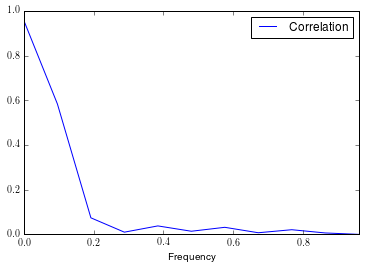

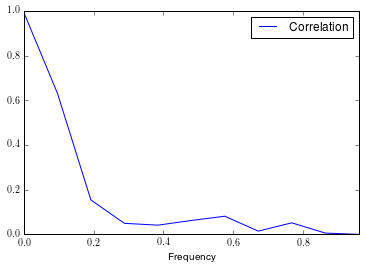

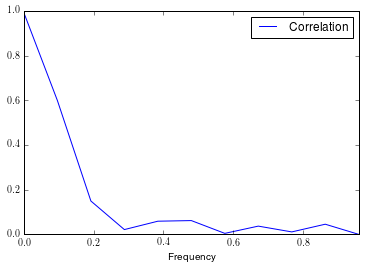

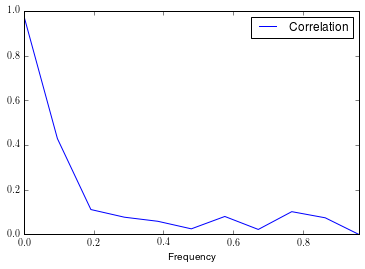

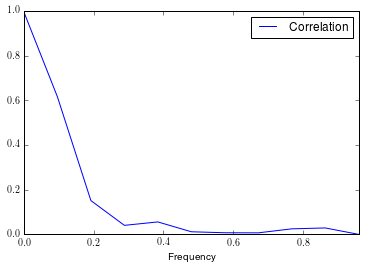

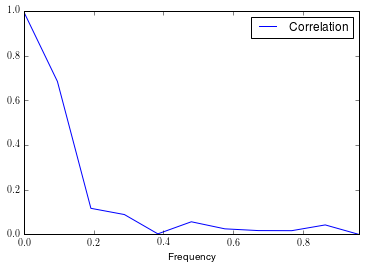

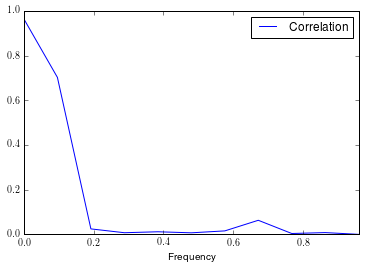

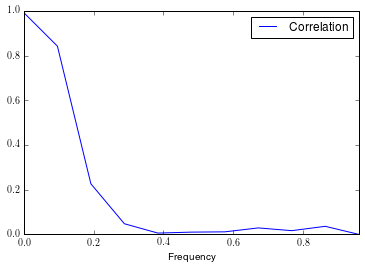

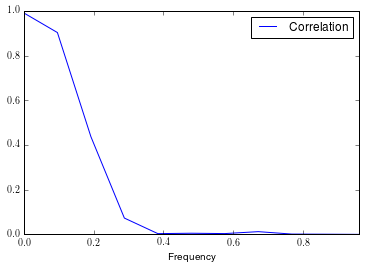

In [71]:
import matplotlib.pyplot as plt
df = data.as_dataframe()
df.groupby("Angle").plot(x='Frequency', y='Correlation')

In [72]:
analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
result = analyzer.execute()

## Results

The results look promising, but I am not sure about the numerical values. Re-check the theoretical values and make some measurements:

$r_{xy} =  \frac{ 0.6 \lambda}{{NA}}$

$r_{z} = \frac{1.4 \lambda \eta}{{NA}^2} $

The problem is that I don't exactly know the NA, which will strongly affect the axial resolution especially. The results look OK in any case.


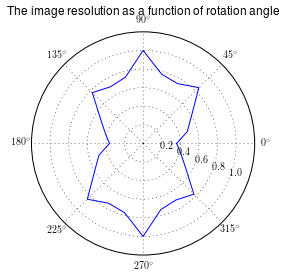

In [73]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(result)
plotter.plot_polar()

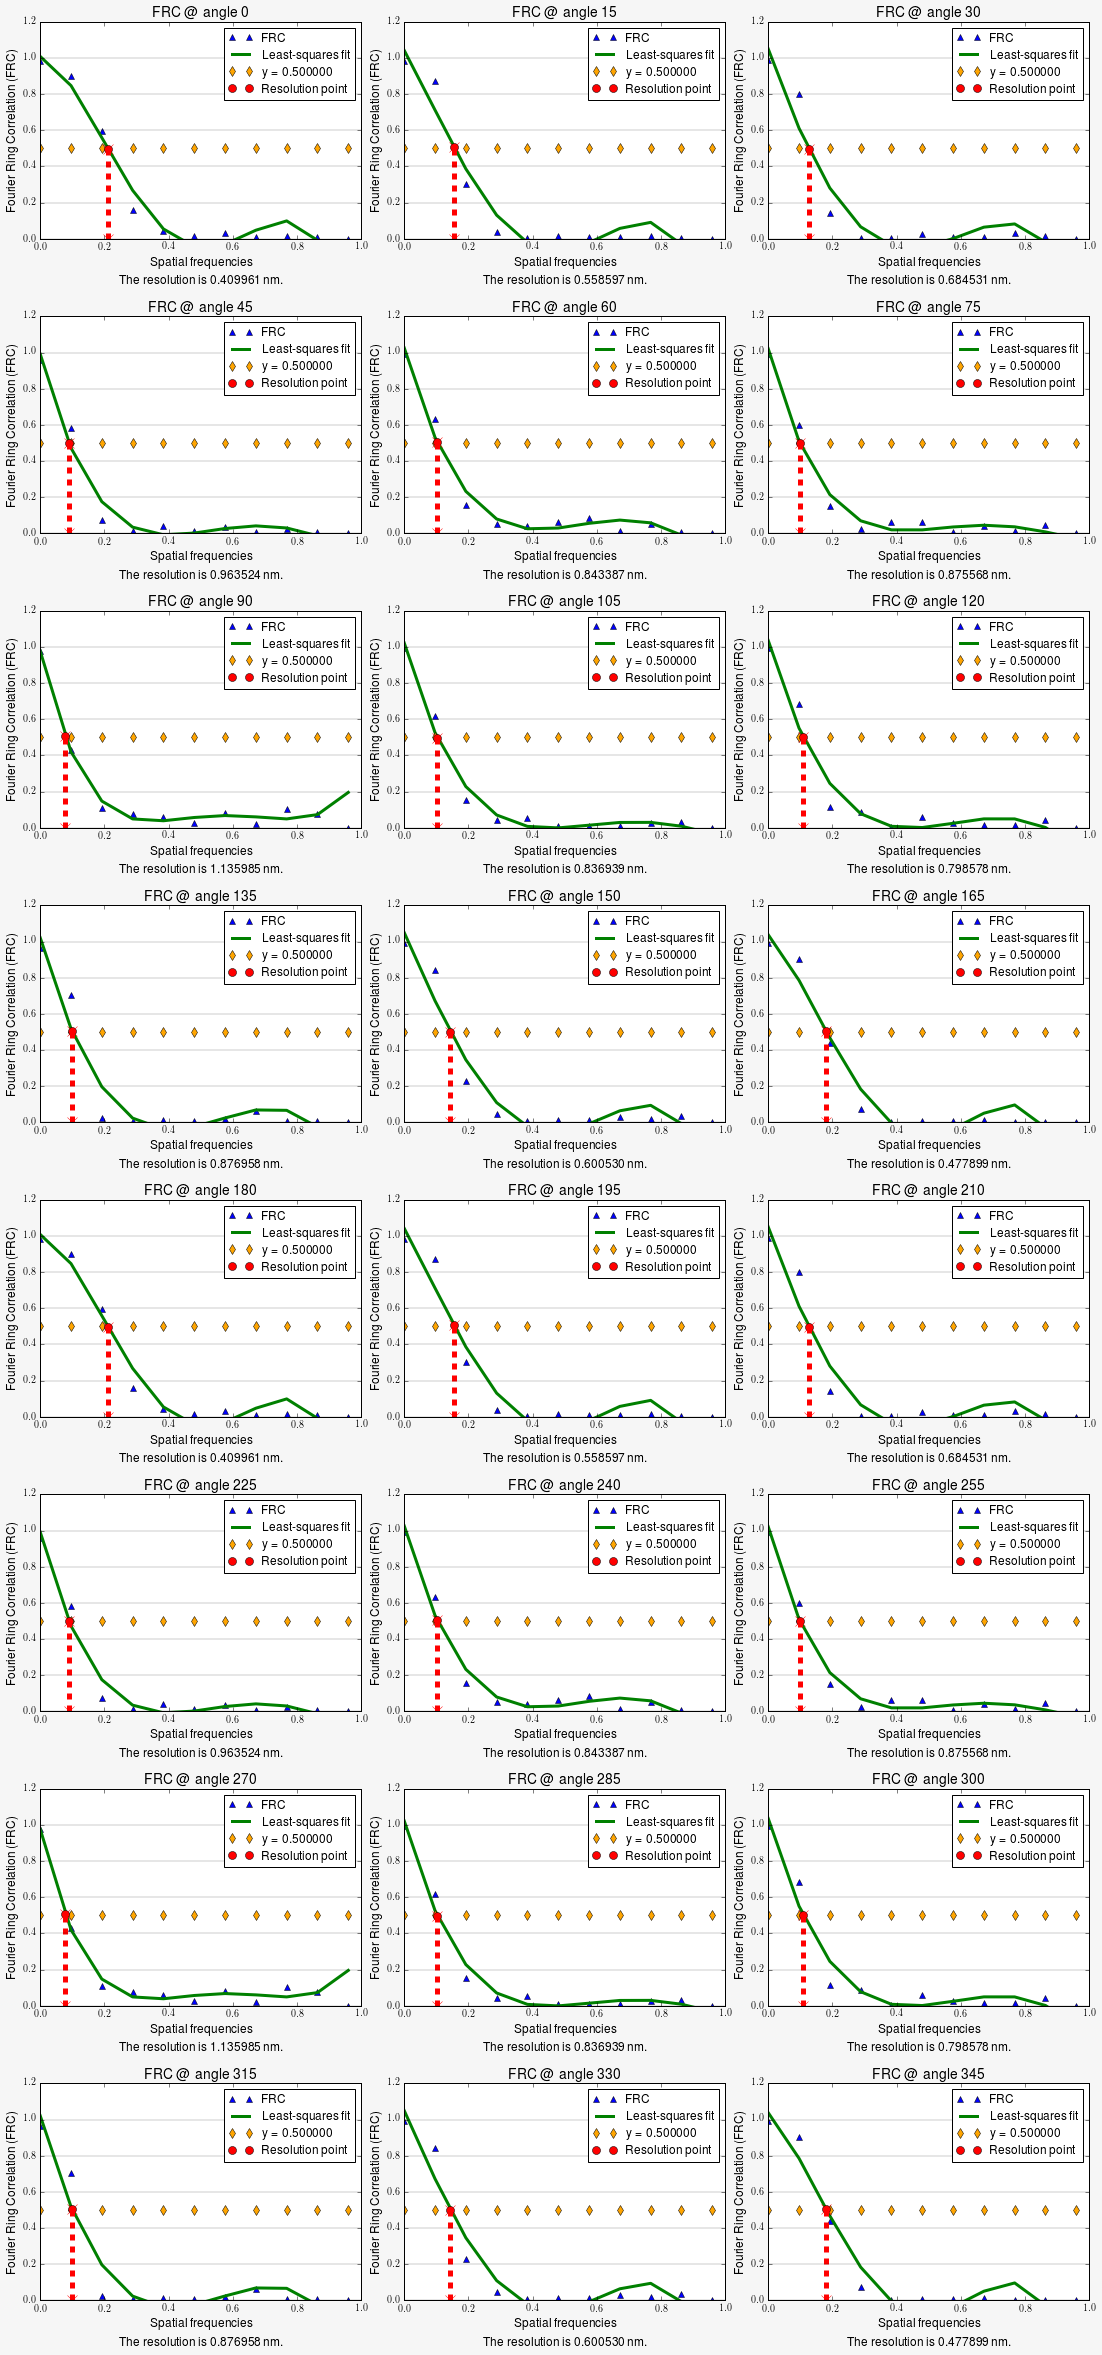

In [74]:
plotter.plot_all()

In [75]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl  %%prun  %%pypy  %%python  %%python2  %%python3